Outline
1. Exploratory Data Analysis (EDA) - what are the features and how they individually affect house prices
2. Recoding - fixing problems we identified in EDA
3. Feature selection - choose which features we include in model 
4. Model building
    

In [1]:
#the necessary modules
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
from sklearn.metrics import mean_absolute_error


In [2]:
#Loading our data set
data_train_file = './data.csv'
data_test_file = './test.csv'

houses = pd.read_csv(data_train_file)

In [3]:
#how many houses and features do we have ?
houses.shape

(4600, 18)

In [4]:
#lets check out what features we have
houses.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [5]:
houses.country.value_counts()

USA    4600
Name: country, dtype: int64

In [6]:
houses.statezip.value_counts()

WA 98103    148
WA 98052    135
WA 98117    132
WA 98115    130
WA 98006    110
           ... 
WA 98047      6
WA 98288      3
WA 98050      2
WA 98354      2
WA 98068      1
Name: statezip, Length: 77, dtype: int64

In [7]:
"The avg price of a house is ${:,.0f}".format(houses.price.mean())

'The avg price of a house is $551,963'

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

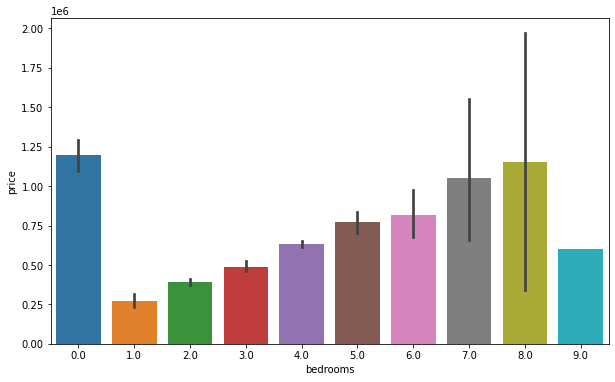

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x=houses.bedrooms, y=houses["price"])

Interesting thing is houses with 9 bedrooms costs less than 4 bedrooms. And some houses have any bedroom. Lets have a look at more details.

In [9]:
#get a price breakdown for each bedroom group
bybedroom = houses.groupby(["bedrooms"]).price.agg([len, min, max])

In [10]:
#problem #1: a huge outlier detected at houses have 3 bedrooms
#problem #2: two houses with 0 bedroom
bybedroom

,len,min,max
bedrooms,,,
0.0,2.0,1095000.0,1295648.0
1.0,38.0,0.0,540000.0
2.0,566.0,0.0,1695000.0
3.0,2032.0,0.0,26590000.0
4.0,1531.0,0.0,4489000.0
5.0,353.0,0.0,7062500.0
6.0,61.0,0.0,3100000.0
7.0,14.0,280000.0,3200000.0
8.0,2.0,340000.0,1970000.0


The house with 9 bedrooms has much less price. Maybe this house is far from city or the owner might want to sell it in hurry

The table above highlighted 2 other problems with the data
1. Two houses have no bedroom
2. Some houses have a price of zero
Let's look at this last problem in more detial

In [11]:
houses_zero = houses[houses.price==0]
print("There are " + str(len(houses_zero))+" houses without a price")

There are 49 houses without a price


49 out of 4600 is not a big deal. However it might confuse our model.

Let's look at price distribution

c:\users\delge\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

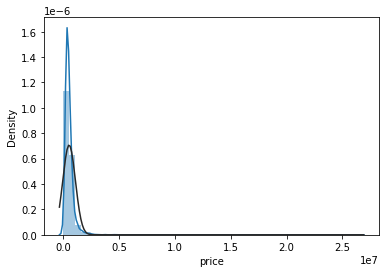

In [12]:
sns.distplot(houses['price'], fit=norm)

The price distribution is in blue, while the normal distribution line is black.

We have 3 problems so far:

1. Houses with 0 bedroom
2. Giant outlier at almost $27M which is 50 times the price of a normal house
3. 49 houses without a price

Let's remove them from the data set

In [13]:
# new dataframe without problem #1 #2 #3
houses_o = houses[(houses.price<2.5*10**6) & (houses.bedrooms>0) & (houses.price>0)].copy()


Another problem is there is too few houses that has more than 6 rooms. So let's merge houses with 6,7,8,9 bedrooms. 

In [14]:
houses_o['bedrooms_recoded'] = houses_o['bedrooms'].replace([7,8,9], 6)

In [15]:
#Let's mark if the house is renovated with symbol renovated_0_1
houses_o['renovated_0_1'] = houses_o['yr_renovated']/houses_o['yr_renovated']
houses_o['renovated_0_1'] = houses_o['renovated_0_1'].fillna(0)

Pearson correlation matrix on non-categoricol features

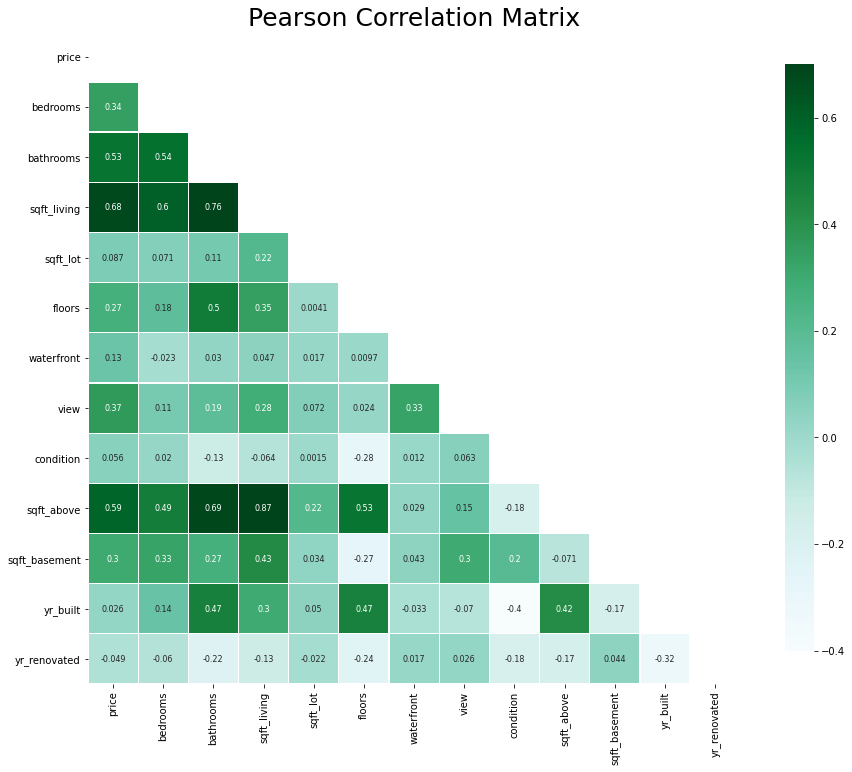

In [16]:
features = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
mask = np.zeros_like(houses_o[features].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix', fontsize = 25)

sns.heatmap(houses_o[features].corr(), linewidths=0.25, vmax = 0.7, square = True, cmap = "BuGn", #"BuGn_r" to reverse 
           linecolor='w', annot=True, annot_kws={"size": 8}, mask=mask,cbar_kws={"shrink": .9});

The best practice to choose features is choose features that highly correlated with house price but not correlated with each other

Let's consider features below for now

1. floors
2. view
3. condition
4. bedrooms_recoded
5. renovated_0_1

Go ahead and separate the price from our features:

In [19]:
# Move our features into the X DataFrame
X = houses_o.loc[:, ['bedrooms_recoded', 'floors', 'view', 'condition', 'renovated_0_1']]

#Move our labels into the y DataFrame
y = houses_o.loc[:, ['price']]

In [21]:
# separate y and X into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
#train a basic multiple regression model and print out the coefficients
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.811
Model:                            OLS   Adj. R-squared (uncentered):              0.811
Method:                 Least Squares   F-statistic:                              2722.
Date:                Mon, 26 Oct 2020   Prob (F-statistic):                        0.00
Time:                        18:55:55   Log-Likelihood:                         -44212.
No. Observations:                3172   AIC:                                  8.843e+04
Df Residuals:                    3167   BIC:                                  8.846e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [23]:
#Ask the model to predict prices in the train and test set based just on our predictor variables
lr = LinearRegression()
lr.fit(X_train, y_train)
test_pre = lr.predict(X_test)
train_pre=lr.predict(X_train)

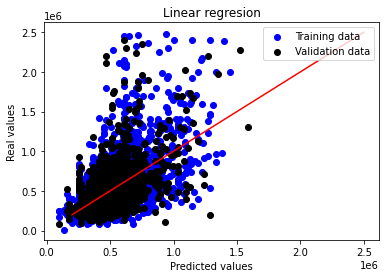

In [28]:
#Now let's plot our predicted values on one axis and the real values on the other axis
plt.scatter(train_pre, y_train, c='blue', label='Training data')
plt.scatter(test_pre, y_test, c="black", label="Validation data")
plt.title("Linear regresion")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc="upper right")
plt.plot([0.2*10**6, 0.25*10**7], [0.2*10**6, 0.25*10**7], c = 'red')
plt.show()